In [2]:
import tensorflow_probability as tfp
import tensorflow as tf
import pandas as pd

tfd = tfp.distributions 

from elicit.core.run import prior_elicitation
from elicit.user.generative_models import ToyModel
from elicit.user.custom_functions import Normal_log

# Parametric-prior approach
## The model
The statistical model of the toy example is an intercept-only normal model with location $\mu$ and random noise $\sigma$. The location parameter $\mu$ is a function of the intercept $\beta_0$.    


\begin{align*}
    \beta_0 &\sim \text{Normal}(\mu_\mu, \sigma_\mu)\quad \quad &\text{Priors}\\
    \sigma &\sim \text{Normal}(0, \sigma_\sigma)\quad \quad &\\
    \mu &= \textbf{1}_N\beta_0 \quad \quad &\text{with obs}=1,\ldots, N\\
    height_i &\sim \text{Normal}(\mu, \sigma) \quad \quad &\text{Likelihood}
\end{align*}


Our goal is to find values for $\lambda = (\mu_\mu, \sigma_\mu, \sigma_\sigma)$.

In [3]:
# implementation of the generative model
??ToyModel

Init signature: ToyModel()
Docstring:      <no docstring>
Source:        
class ToyModel:
    def __call__(self, ground_truth, prior_samples, N):
        # number of observations (intercept-only)
        X = tf.ones((1,N))
        # linear predictor (= mu)
        epred = tf.expand_dims(prior_samples[:,:,0],-1) @ X
        # data-generating model 
        likelihood = tfd.Normal(loc=epred,
                                scale=tf.expand_dims(prior_samples[:,:,1],-1))
        # prior predictive distribution (=height)
        ypred = likelihood.sample()
        
        return dict(likelihood = likelihood,     
                    ypred = ypred,                 
                    epred = epred,
                    prior_samples = prior_samples                 
                    )
File:           c:\users\bockting\documents\github\prior_elicitation\elicit\user\generative_models.py
Type:           type
Subclasses:     

## Expert information
**Example elicitation approach:**

The expert is asked w.r.t.
+ their *median* ($Q_{50}$; value for which there is a 50/50 chance of being more or less)
+ the lower and upper quartiles ($Q_{25}$ and $Q_{75}$ respectively; the expert should judge it to be equally likely for $y$ to be below $Q_{25}$ or between $Q_{25}$ and $Q_{50}$, and they should also judge it equally likely that $y$ would be between $Q_{50}$ and $Q_{75}$ or above $Q_{75}$.)
+ the lower and upper boundary ($Q_{5}$ and $Q_{95}$ respectively; equivalent to min and max but more stable)
+ a coherence check: $Q_{5} < Q_{25} < Q_{50} < Q_{75} < Q_{95}$ (ranking should not be violated)


In [4]:
# path to expert data
expert_info = pd.read_pickle("../toyexample_expert/elicited_statistics.pkl")

# show expert information in terms of quantiles
expert_data = pd.DataFrame(
    tf.round(expert_info["quantiles_ypred"]), 
    columns=[f"Q_{i}" for i in [5,25,50,75,95]], 
    index = ["true"]
)

expert_data

,Q_5,Q_25,Q_50,Q_75,Q_95
true,154.0,166.0,170.0,174.0,186.0


In [5]:
normal_log = Normal_log()

prior_elicitation(
    model_parameters=dict(
        mu=dict(family=normal_log, 
                hyperparams_dict={
                      "mu_loc": tfd.Uniform(100.,300.),
                      "log_mu_scale": tfd.Uniform(0., 5)
                      },
                param_scaling=1.
                ),
        sigma=dict(family=tfd.HalfNormal,
                   hyperparams_dict={
                      "sigma_scale": tfd.Uniform(1.,50.)
                      },
                   param_scaling=1.
                   ),
        independence = False
        ),
    expert_data=dict(
        data=expert_info,
        from_ground_truth = False
        ),
    generative_model=dict(
        model=ToyModel,
        additional_model_args={
            "N": 200
            }
        ),
    target_quantities=dict(
        ypred=dict(
            elicitation_method="quantiles",
            quantiles_specs=(5, 25, 50, 75, 95),
            loss_components = "all"
            )
        ),
    optimization_settings=dict(
        optimizer_specs={
            "learning_rate": 0.1,
            "clipnorm": 1.0
            }
        ),
    training_settings=dict(
        method="parametric_prior",
        sim_id="toy_example",
        warmup_initializations=50,
        seed=0,
        view_ep=50,
        epochs=500
    )
    )

|||||||||||||||||||||||||||||||||||||||||||||||||| 
epoch_time: 0.722 sec
Epoch: 0, loss: 2.03578, lr: 0.100000
epoch_time: 0.604 sec
Epoch: 50, loss: 0.60201, lr: 0.100000
Estimated time until completion: 00:04:37
epoch_time: 0.644 sec
Epoch: 100, loss: 0.08066, lr: 0.100000
Estimated time until completion: 00:04:06
epoch_time: 0.550 sec
Epoch: 150, loss: 0.07663, lr: 0.100000
Estimated time until completion: 00:03:32
epoch_time: 0.628 sec
Epoch: 200, loss: 0.07383, lr: 0.100000
Estimated time until completion: 00:02:59
epoch_time: 0.674 sec
Epoch: 250, loss: 0.07951, lr: 0.100000
Estimated time until completion: 00:02:33
epoch_time: 0.740 sec
Epoch: 300, loss: 0.08401, lr: 0.100000
Estimated time until completion: 00:02:03
epoch_time: 0.573 sec
Epoch: 350, loss: 0.08512, lr: 0.100000
Estimated time until completion: 00:01:32
epoch_time: 0.785 sec
Epoch: 400, loss: 0.08110, lr: 0.100000
Estimated time until completion: 00:01:01
epoch_time: 0.646 sec
Epoch: 450, loss: 0.08697, lr: 0.10

## Results

### Loss function and convergence

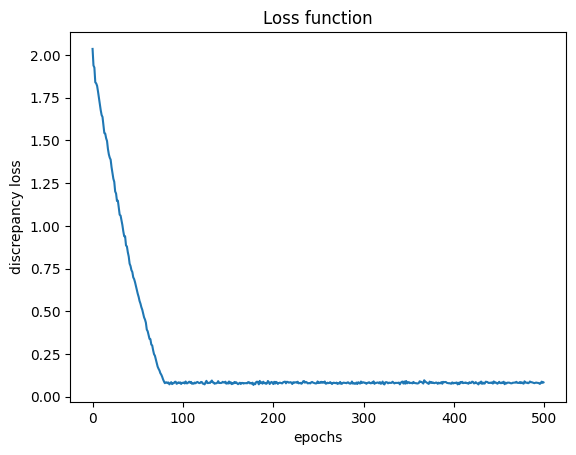

In [6]:
from elicit.plotting import func
path = "./elicit/results/parametric_prior/toy_example_0"

func.plot_loss(path)

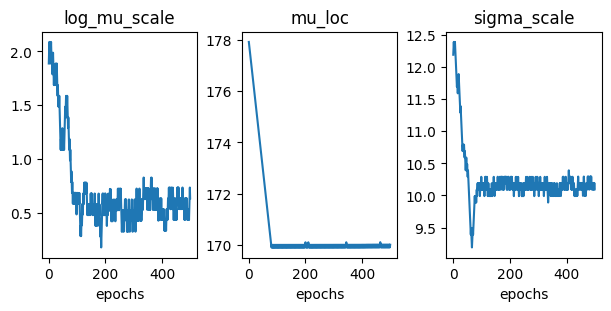

In [7]:
func.plot_convergence(path)

### Elicited statistics 

In [8]:
model_data = pd.DataFrame(
    tf.round(tf.reduce_mean(pd.read_pickle(path+"/elicited_statistics.pkl")["quantiles_ypred"],0)[None,:]),
    columns=[f"Q_{i}" for i in [5,25,50,75,95]], 
    index=["model"])

pd.concat([expert_data, model_data])

,Q_5,Q_25,Q_50,Q_75,Q_95
true,154.0,166.0,170.0,174.0,186.0
model,153.0,166.0,170.0,174.0,186.0


### Prior distributions

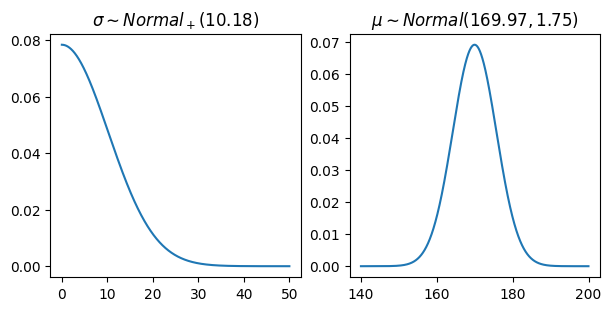

In [9]:
import matplotlib.pyplot as plt

hyp=pd.read_pickle(path+"/final_results.pkl")["hyperparameter"]
learned_hyp=tf.reduce_mean(tf.stack([hyp[k][-30:] for k in hyp],-1), 0)
gd = pd.read_pickle(path+"/global_dict.pkl")

xrge = tf.range(0.,50., 0.01)
xrge2 = tf.range(140.,200., 0.01)
sigma = gd["model_parameters"]["sigma"]["family"](learned_hyp[2]).prob(xrge)
mu = gd["model_parameters"]["mu"]["family"](learned_hyp[1], tf.exp(learned_hyp[0])).prob(xrge2)

_, axs = plt.subplots(1,2, constrained_layout=True, figsize=(6,3))
axs[0].plot(xrge, sigma)
axs[0].set_title(rf"$\sigma \sim Normal_+({learned_hyp[2]:.2f})$")
axs[1].plot(xrge2, mu)
axs[1].set_title(rf"$\mu \sim Normal({learned_hyp[1]:.2f}, {tf.exp(learned_hyp[0]):.2f})$")
plt.show()